In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
# header = None --> Header row is not available for csv
# index_col[0] = first column uesd as index
df = pd.read_csv('twitter_sentiment.csv', header=None, index_col=[0]) 

In [3]:
df.head()

,1,2,3
0,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
# .reset_index() --> reset existing index
# drop=true is used to discard the old index instead of adding it as a new column.
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']

In [5]:
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df.isnull().sum()

sentiment      0
text         686
dtype: int64

In [8]:
df.shape

(75682, 2)

In [9]:
df.dropna(inplace=True) 

In [10]:
df = df[df['text'].apply(len)>1] 

In [11]:
df['sentiment'].value_counts()

Negative      22530
Positive      20844
Neutral       18285
Irrelevant    12988
Name: sentiment, dtype: int64

In [12]:
import preprocess_kgptalkie as ps # NLP preprocessing library
df = ps.get_basic_features(df)

In [13]:
df

,sentiment,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Positive,im getting on borderlands and i will murder yo...,43,11,3.909091,6,0,0,1,0
1,Positive,I am coming to the borders and I will kill you...,40,12,3.333333,6,0,0,1,2
2,Positive,im getting on borderlands and i will kill you ...,41,10,4.100000,5,0,0,1,0
3,Positive,im coming on borderlands and i will murder you...,42,10,4.200000,5,0,0,1,0
4,Positive,im getting on borderlands 2 and i will murder ...,46,12,3.833333,6,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
75677,Irrelevant,⭐️ Toronto is the arts and culture capital of ...,235,47,5.000000,20,0,0,6,1
75678,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,202,46,4.391304,15,0,0,4,10
75679,Positive,Today sucked so it’s time to drink wine n play...,97,24,4.041667,9,0,0,1,1
75680,Positive,Bought a fraction of Microsoft today. Small wins.,42,8,5.250000,2,0,0,2,0


In [14]:
# importing visualizing libraries
import matplotlib.pyplot as plt
import seaborn as sns

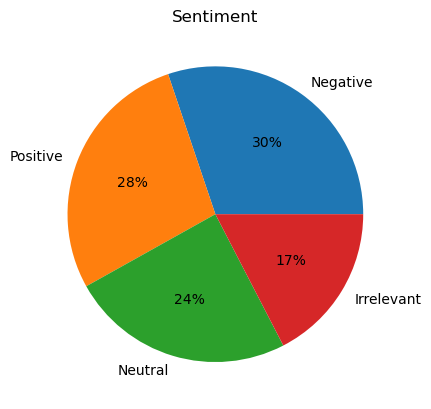

In [15]:
# visualizing the data
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Sentiment')
plt.ylabel('')
plt.show()

In [16]:
# word cloud used to generate word cloud visualizations
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

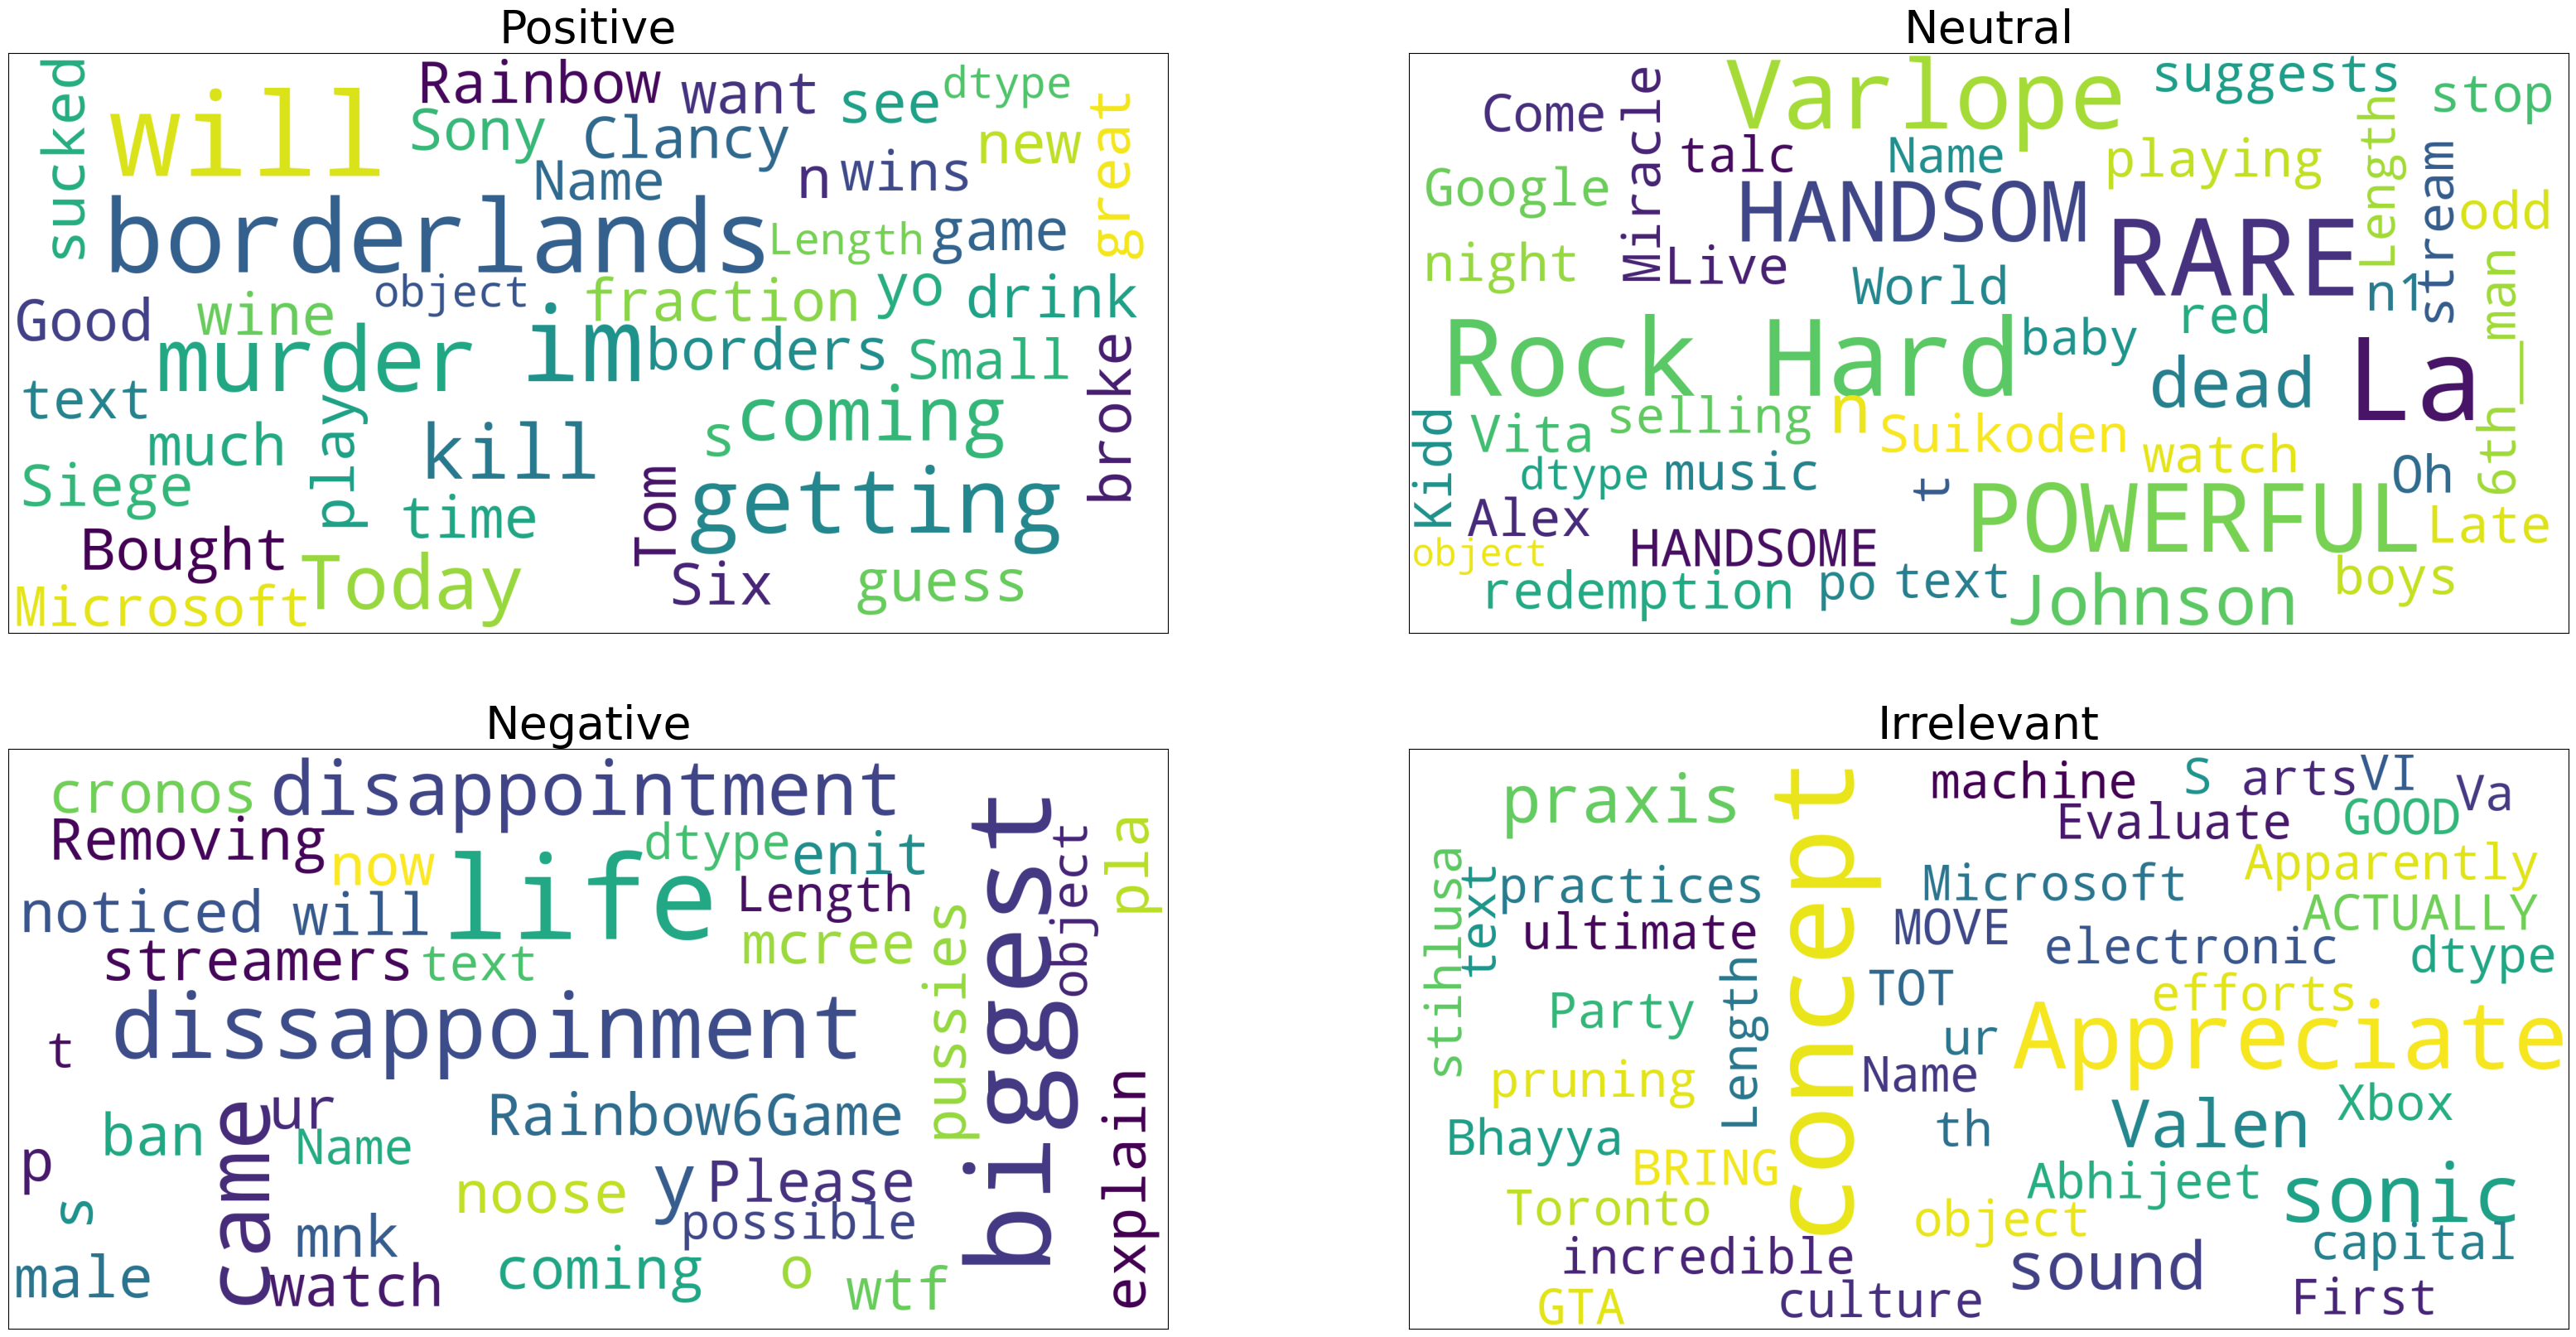

In [17]:
# plotting word clouds
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

In [18]:
# preprocessing text
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x)) # This line removes "RT" (Retweet) tags from the text

In [19]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [20]:
# model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [21]:
# evaluation
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)

result = round((accuracy_score(y_test, predictions)),2)
print(f'Accuracy of model {result*100}%')

Accuracy of model 91.0%


In [22]:
# save model
import pickle

pickle.dump(clf, open('twitter_sentiment.pkl', 'wb'))

In [23]:
# some predictions
res = clf.predict(['i love my country'])
res

array(['Positive'], dtype=object)

In [25]:
res = clf.predict(['Hello'])
res

array(['Neutral'], dtype=object)